In [1]:
#done 23-july-23
#!rm -rf './scattering_transform/'
#!git clone 'https://github.com/SihaoCheng/scattering_transform.git' './scattering_transform/'

In [2]:
import torch
import torch.fft

In [3]:
import os
import sys

In [4]:
root_dir = os.getcwd()

In [5]:
sys.path.append(root_dir+'/scattering_transform/')

In [6]:
# import scattering package
import scattering

use torch backend


In [7]:
from scattering.Scattering2d import get_scattering_index

In [8]:
import numpy as np 

In [9]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
def get_stats(maps,bins_pw=30,bs=100):
    # maps numpy (N,W,H)
    Nmaps,M,N = maps.shape
    #
    # scattering coeff engine
    #
    J = int(np.log2(min(M,N))) - 1
    L = 4
    st_calc = scattering.Scattering2d(M, N, J, L)
    
    coeffs = st_calc.scattering_coef(maps)
    
    s1 =  np.log10(coeffs['S1_iso'].cpu().numpy())
    mean_s1 = np.mean(s1,axis=0)
    std_s1  = np.std(s1,axis=0)
    
    s21 = np.log10(coeffs['s21'].cpu().detach().numpy())
    mean_s21 = np.mean(s21,axis=0)[np.triu_indices(J)]
    std_s21 = np.std(s21,axis=0)[np.triu_indices(J)]
    
    s22 = np.log10(coeffs['s22'].cpu().detach().numpy())
    mean_s22 = np.mean(s22,axis=0)[np.triu_indices(J)]
    std_s22 = np.std(s22,axis=0)[np.triu_indices(J)]
    
    # power spectrum
    pw, kr = scattering.get_power_spectrum(maps,
                                        k_range=np.logspace(0,np.log10(M/2*1.4), 
                                        bins_pw+1),device='cpu')
    
    pw = pw.cpu().numpy()
    mean_pw = np.mean(pw, axis=0)
    std_pw  = np.std(pw, axis=0)
    
    kr = kr.cpu().numpy()

    # bis pectrum
    bi_calc = scattering.Bispectrum_Calculator(M,N, 
                    k_range=np.logspace(0,np.log10(M/2*1.4), J-1),
                    device='cpu')
    
    bispec = bi_calc.forward(maps).cpu().numpy()
    mean_bi = np.mean(bispec,axis=0)
    std_bi  = np.std(bispec,axis=0)
    
    
    # tri spectrum
    tri_calc = scattering.Trispectrum_Calculator(M,N,
                    k_range=np.logspace(0,np.log10(M/2*1.4), J-1),
                    device='cpu')
    trispec = tri_calc.forward(maps).cpu().numpy()
    mean_tri = np.mean(trispec,axis=0)
    std_tri  = np.std(trispec,axis=0)
    
    
    #
    # scattering covariance
    #
    select_and_index = get_scattering_index(J, L, normalization='P00', C11_criteria='j2>=j1')
    if Nmaps > 1:
        nb = Nmaps//bs
        all_mean_c01 = []
        all_std_c01  = []
        all_mean_c11 = []
        all_std_c11  = []
        for i in range(nb):
            cov_coef = st_calc.scattering_cov(maps[i*bs:(i+1)*bs])
            c01 = cov_coef['C01_iso'][:,select_and_index['select_2_iso']].cpu().numpy()
            all_mean_c01.append(np.mean(c01,axis=0))
            all_std_c01.append(np.std(c01,axis=0))
    
            c11 = cov_coef['C11_iso'][:,select_and_index['select_3_iso']].cpu().numpy()
            all_mean_c11.append(np.mean(c11,axis=0))
            all_std_c11.append(np.std(c11,axis=0))
    
    
        all_mean_c01 = np.array(all_mean_c01)
        all_std_c01 = np.array(all_std_c01)
    
        all_invstd2_c01 = 1./all_std_c01**2
        invstd2_c01 = np.sum(all_invstd2_c01, axis=0)
        std2_c01 = 1./invstd2_c01
        std_c01 = np.sqrt(std2_c01)
        tst = np.sum(all_invstd2_c01 * all_mean_c01,axis=0)
        mean_c01 = tst*std2_c01

        all_mean_c11 = np.array(all_mean_c11)
        all_std_c11 = np.array(all_std_c11)

        all_invstd2_c11 = 1./all_std_c11**2
        invstd2_c11 = np.sum(all_invstd2_c11, axis=0)
        std2_c11 = 1./invstd2_c11
        std_c11 = np.sqrt(std2_c11)
        tst = np.sum(all_invstd2_c11 * all_mean_c11,axis=0)
        mean_c11 = tst*std2_c11
    
    else: # single image
        cov_coef = st_calc.scattering_cov(maps)
        c01 = cov_coef['C01_iso'][:,select_and_index['select_2_iso']].cpu().numpy()
        mean_c01  = np.mean(c01,axis=0)
        std_c01   = np.std(c01,axis=0) # 0
        c11 = cov_coef['C11_iso'][:,select_and_index['select_3_iso']].cpu().numpy()
        mean_c11  = np.mean(c11,axis=0)
        std_c11   = np.std(c11,axis=0)
        
        
    return {
        "s1":(mean_s1,std_s1), "s21":(mean_s21,std_s21), "s22":(mean_s22,std_s22),
        "pw":(mean_pw,std_pw,kr), "bi":(mean_bi,std_bi), "tri":(mean_tri,std_tri),
        "c01":(mean_c01,std_c01), "c11":(mean_c11,std_c11)
           }

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Data :
- CosmoGan: train, valid, gene
- WCRG : gene

In [12]:
dgan_dir = root_dir+"/DGAN/"

# Transformed Maps

In [13]:
wcrg_dir = root_dir+"/SynthsTrans/"

In [14]:
#maps = np.load(dgan_dir+'cosmo_primary_128_5k_train_trans.npy')
maps = np.load(wcrg_dir+'wcrg_128_500_trans.npy')

In [15]:
maps_train_trans = np.load(dgan_dir+'cosmo_primary_128_5k_train_trans.npy')
maps_valid_trans = np.load(dgan_dir+'cosmo_primary_128_5k_valid_trans.npy')
maps_gen_trans   = np.load(dgan_dir+'cosmogan_maps_128_5k_1_trans.npy')
maps_wcrg_gen_trans = np.load(wcrg_dir+'wcrg_128_500_trans.npy')
map_micro_gen_trans = np.load(root_dir+'/micro_gen_500.npy')

In [16]:
maps_train_trans.shape, map_micro_gen_trans.shape

((5000, 128, 128), (500, 128, 128))

In [17]:
Nscat=500 # for memory on K80 CCin2P3

In [18]:
stat_train_trans = get_stats(maps_train_trans[:Nscat])
stat_valid_trans = get_stats(maps_valid_trans[:Nscat])
stat_gen_trans= get_stats(maps_gen_trans[:Nscat])
stat_wcrg_gen_trans = get_stats(maps_wcrg_gen_trans[:Nscat])
stat_micro_gen_trans = get_stats(map_micro_gen_trans[:Nscat])

In [19]:
def plot_stats(data1,data2=None,data3=None,data4=None,
               colors=["blue","gray","green","red"],
              labels=["train","valid","dgan","wcrg"],
              figsize=(14,6), save=False, figname="stats.pdf", figtitle=None):
    
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(4,3)
    ax00 = fig.add_subplot(gs[0, 0])
    ax01 = fig.add_subplot(gs[0, 1])
    ax02 = fig.add_subplot(gs[0, 2])
    ax10 = fig.add_subplot(gs[1, 0])
    ax11 = fig.add_subplot(gs[1, 1])
    ax12 = fig.add_subplot(gs[1, 2])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])

    #fig, ax= subplots(2,3,figsize=figsize)
    capsize=2
    ms=3
    
    #####
    # Power spectrum
    #####
    y,yerr,_ = data1['pw']
    n_val = len(y)
    ax00.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr,_ = data2['pw']
        assert n_val == len(y), "data2 pw len missmatch"
        ax00.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr,_ = data3['pw']
        assert n_val == len(y), "data3 pw len missmatch"
        ax00.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr,_ = data4['pw']
        assert n_val == len(y), "data4 pw len missmatch"
        ax00.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax00.set_title('Power spectrum')
    ax00.legend();

    #####
    # Bi spectrum
    #####
    y,yerr = data1['bi']
    n_val = len(y)
    ax01.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['bi']
        assert n_val == len(y), "data2 bi len missmatch"
        ax01.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['bi']
        assert n_val == len(y), "data3 bi len missmatch"
        ax01.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['bi']
        assert n_val == len(y), "data4 bi len missmatch"
        ax01.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax01.set_title('Bi-spectrum')
    ax01.legend();

    
    #####
    # Tri spectrum
    #####
    y,yerr = data1['tri']
    n_val = len(y)
    ax02.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['tri']
        assert n_val == len(y), "data2 tri len missmatch"
        ax02.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['tri']
        assert n_val == len(y), "data3 tri len missmatch"
        ax02.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['tri']
        assert n_val == len(y), "data4 tri len missmatch"
        ax02.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax02.set_title('Tri-spectrum')
    ax02.legend();

    #####
    # S1_iso
    #####
    y,yerr = data1['s1']
    n_val = len(y)
    ax10.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['s1']
        assert n_val == len(y), "data2 s1 len missmatch"
        ax10.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yer = data3['s1']
        assert n_val == len(y), "data3 s1 len missmatch"
        ax10.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['s1']
        assert n_val == len(y), "data4 s1 len missmatch"
        ax10.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax10.set_title('S1 iso')
    ax10.legend();

    
    #####
    # s21
    #####
    y,yerr = data1['s21']
    n_val = len(y)
    ax11.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['s21']
        assert n_val == len(y), "data2 s21 len missmatch"
        ax11.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['s21']
        assert n_val == len(y), "data3 s21 len missmatch"
        ax11.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['s21']
        assert n_val == len(y), "data4 s21 len missmatch"
        ax11.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax11.set_title('s21')
    ax11.legend();

    
    #####
    # s22
    #####
    y,yerr = data1['s22']
    n_val = len(y)
    ax12.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['s22']
        assert n_val == len(y), "data2 s22 len missmatch"
        ax12.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['s22']
        assert n_val == len(y), "data3 s22 len missmatch"
        ax12.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['s22']
        assert n_val == len(y), "data4 s22 len missmatch"
        ax12.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax12.set_title('s22')
    ax12.legend();
    
    ####
    #c01 iso
    ####
    y,yerr = data1['c01']
    n_val = len(y)
    ax2.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['c01']
        assert n_val == len(y), "data2 c01 len missmatch"
        ax2.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['c01']
        assert n_val == len(y), "data3 c01 len missmatch"
        ax2.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['c01']
        assert n_val == len(y), "data4 c01 len missmatch"
        ax2.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax2.set_title('C01 iso')
    ax2.legend();

    
    ####
    #c11 iso
    ####
    y,yerr = data1['c11']
    n_val = len(y)
    ax3.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[0],c=colors[0],
                   fmt='o',ms=ms,capsize=capsize)
    if data2 is not None:
        y,yerr = data2['c11']
        assert n_val == len(y), "data2 c11 len missmatch"
        ax3.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[1],c=colors[1],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data3 is not None:
        y,yerr = data3['c11']
        assert n_val == len(y), "data3 c11 len missmatch"
        ax3.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[2],c=colors[2],
                   fmt='o',ms=ms,capsize=capsize)
        
    if data4 is not None:
        y,yerr = data4['c11']
        assert n_val == len(y), "data4 c11 len missmatch"
        ax3.errorbar(np.arange(n_val),y,yerr=yerr,label=labels[3],c=colors[3],
                   fmt='o',ms=ms,capsize=capsize)

    ax3.set_title('C11 iso')
    ax3.legend();

    if figtitle is not None:
        fig.suptitle(figtitle)
    

    #plt.show()
    if save:
        plt.savefig(figname)

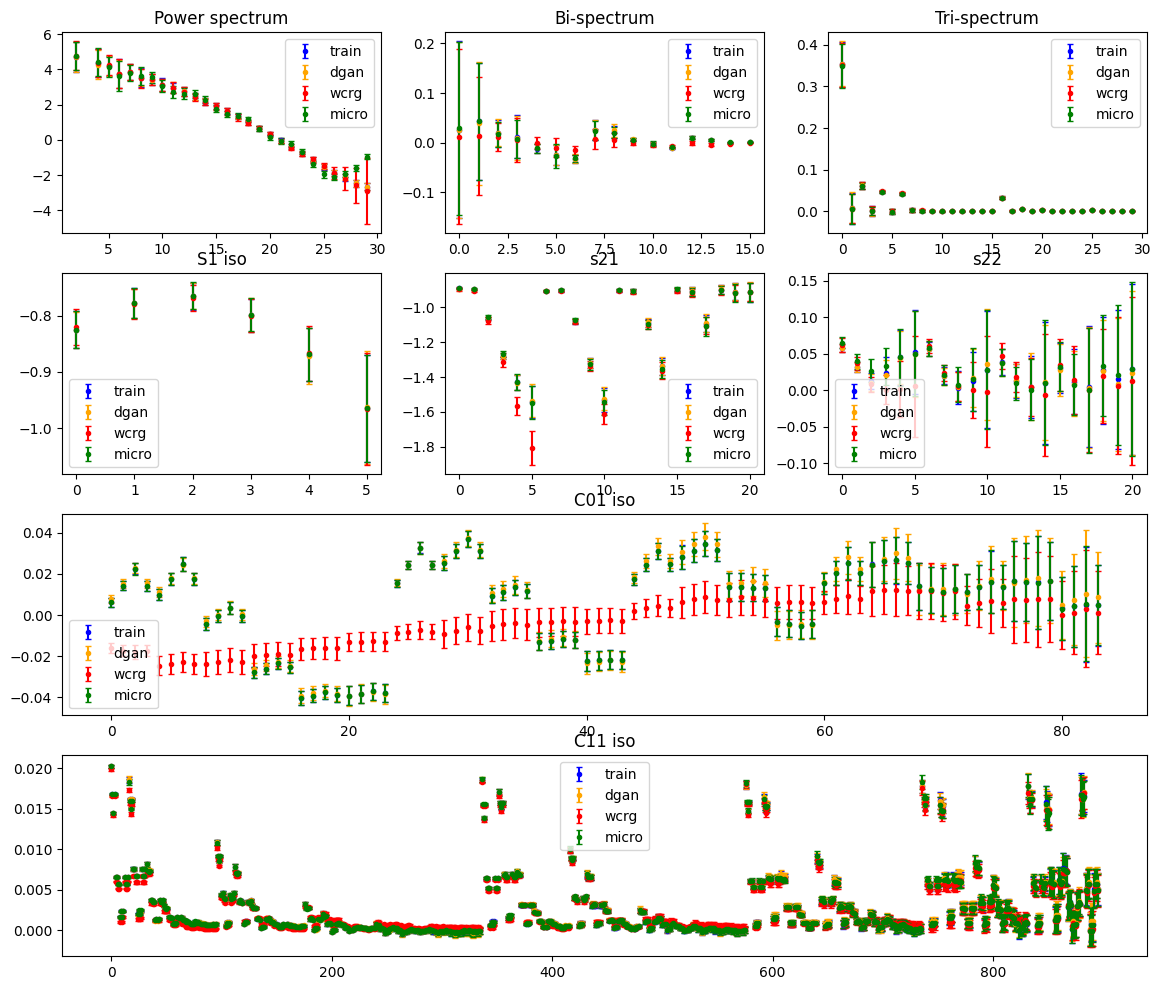

In [20]:
plot_stats(stat_train_trans,stat_gen_trans,stat_wcrg_gen_trans,stat_micro_gen_trans,
           figsize=(14,12),
           labels=["train","dgan","wcrg","micro"],
          colors=["blue","orange","red","green"])#,save=True,figname='dgan_wcrg_micro_trans_stats_withCov.png')

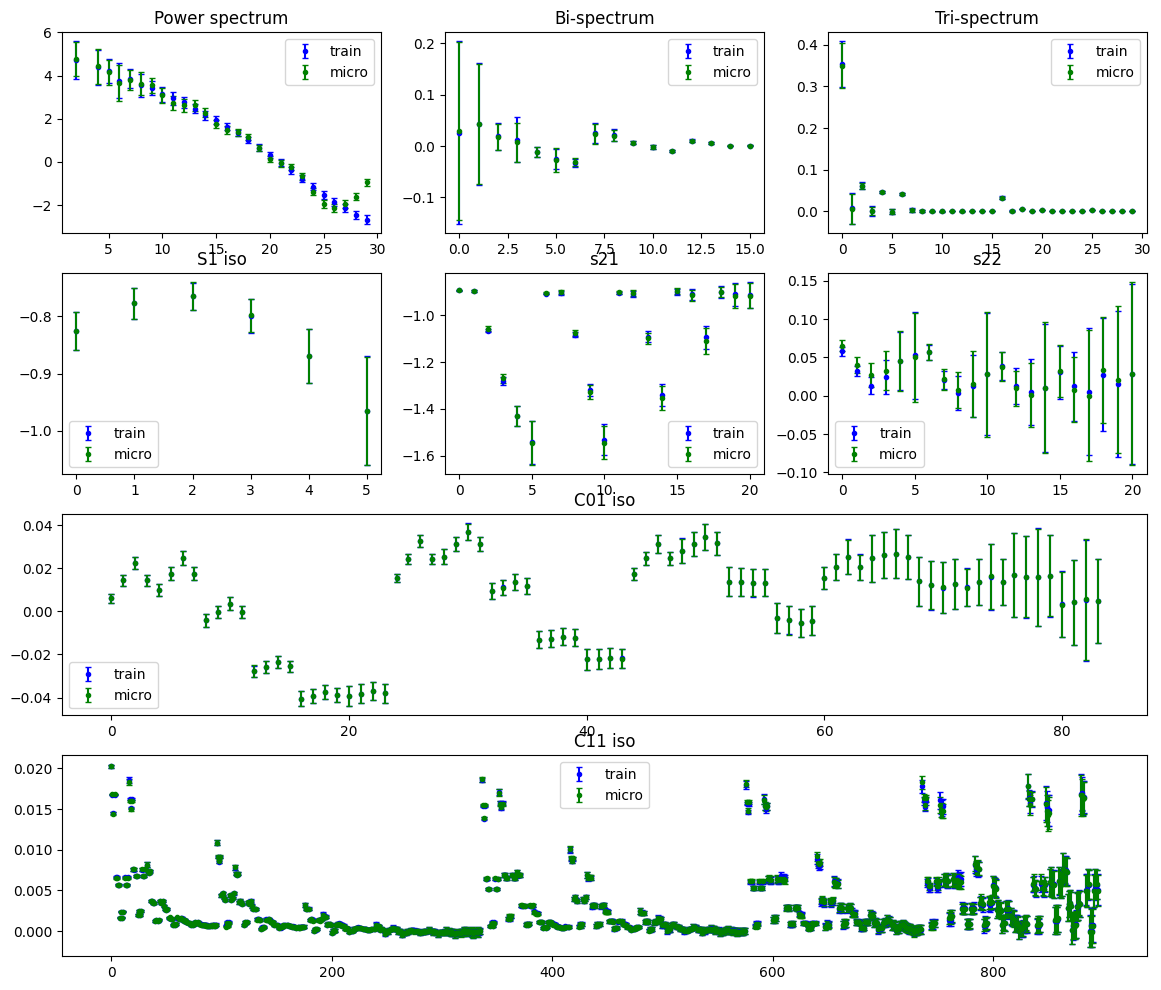

In [21]:
plot_stats(stat_train_trans,stat_micro_gen_trans,
           figsize=(14,12),
           labels=["train","micro"],
          colors=["blue","green"])#,save=True,figname='dgan_wcrg_micro_trans_stats_withCov.png')

## Stat of Train & WCRG maps at L=64

In [55]:
maps_train_64 = np.load(wcrg_dir+'train_64_500_trans.npy')

In [56]:
maps_wcrg_64 = np.load(wcrg_dir+'wcrg_64_500_trans.npy')

In [57]:
maps_train_64.shape, maps_wcrg_64.shape

((500, 64, 64), (500, 64, 64))

In [58]:
stat_train_64 = get_stats(maps_train_64)
stat_wcrg_64  = get_stats(maps_wcrg_64)

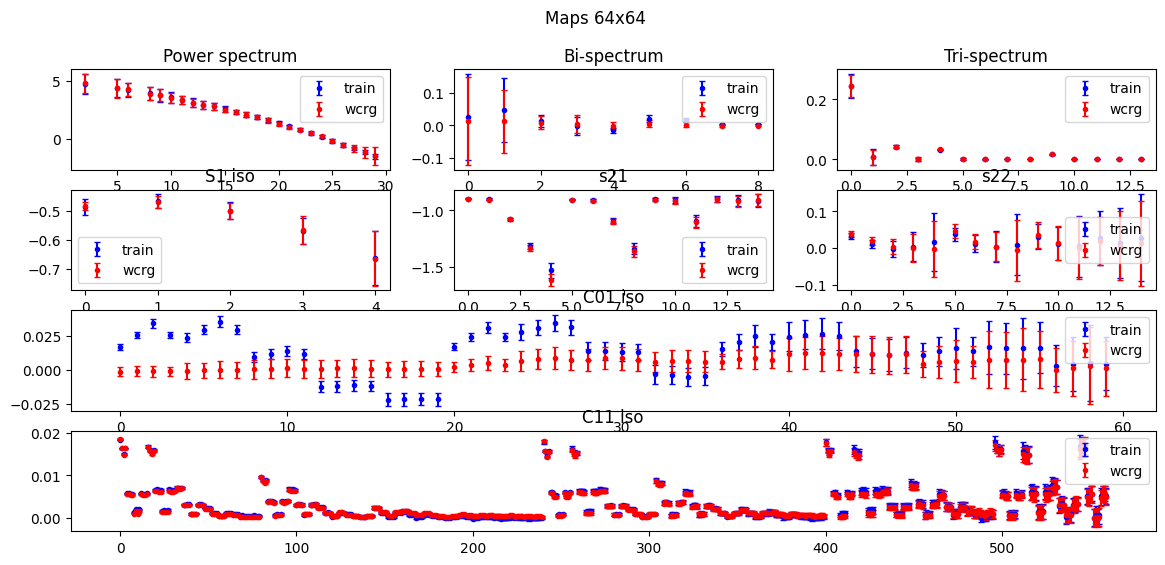

In [61]:
plot_stats(stat_train_64,stat_wcrg_64,
          colors=["blue","red"], labels=['train','wcrg'],figtitle='Maps 64x64',
        save=True,figname='train_wcrg_trans_64.png')

## Stat of maps generated by microcanic with scaled C01 

In [22]:
maps = np.load('micro_3testC01_trans.npy')  # scaling 0, 1, 2

In [27]:
maps.shape

(3, 128, 128)

In [23]:
stat_micro_C01_0 = get_stats(maps[:1])
stat_micro_C01_1 = get_stats(maps[1:2])


In [24]:
stat_ref_micro = get_stats(maps_train_trans[:1])

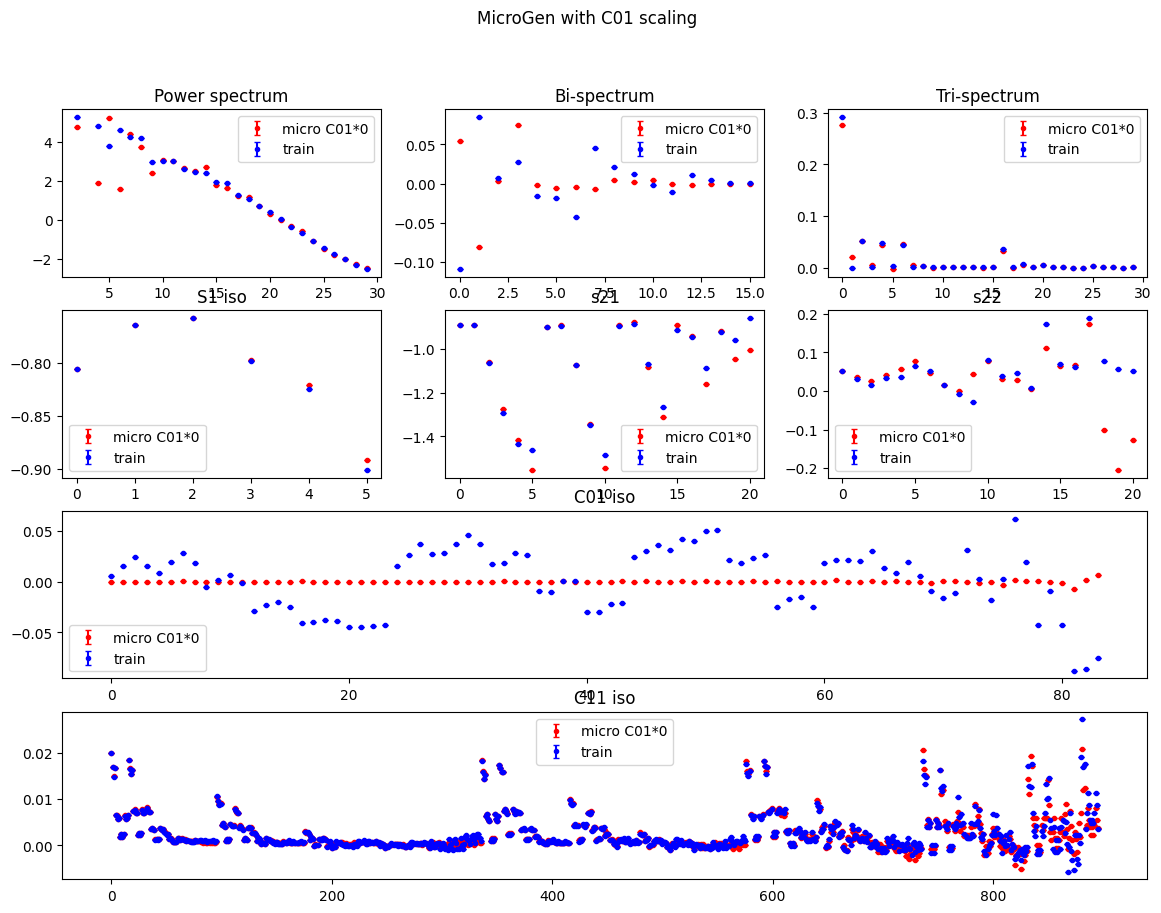

In [28]:
plot_stats(stat_micro_C01_0,stat_ref_micro,
          colors=["red","blue"], labels=['micro C01*0','train'],figtitle='MicroGen with C01 scaling',
        save=True,figname='micro_3testC01_trans.png',figsize=(14,10))

# raw maps

In [76]:
maps_train = np.load(dgan_dir+'cosmo_primary_128_5k_train.npy')
maps_valid = np.load(dgan_dir+'cosmo_primary_128_5k_valid.npy')
maps_gen   = np.load(dgan_dir+'cosmogan_maps_128_5k_1.npy')

In [77]:
Nscat=500 # for memory on K80 CCin2P3

In [78]:
stat_train = get_stats(maps_train[:Nscat])
stat_valid = get_stats(maps_valid[:Nscat])
stat_gen= get_stats(maps_gen[:Nscat])

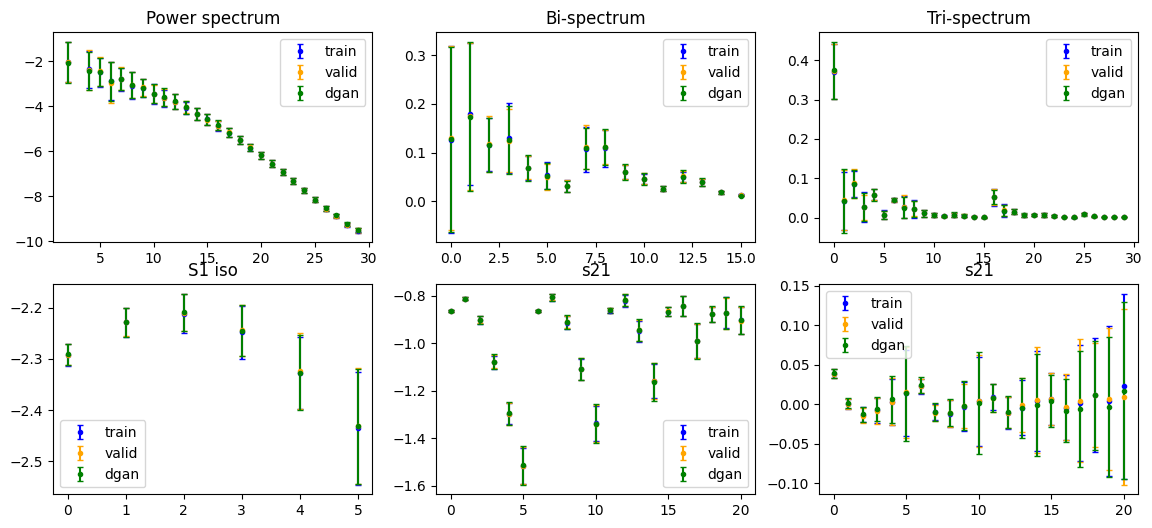

In [79]:
plot_stats(stat_train,stat_valid,stat_gen,
          colors=["blue","orange","green","red"],save=True,figname='dgan_raw_stats.png')

# Peak counts stat

In [76]:
#! rm -rf './DifferentiableHOS'
#! git clone https://github.com/LSSTDESC/DifferentiableHOS.git
#! git clone https://github.com/CosmoStat/lenspack.git

Cloning into 'lenspack'...
remote: Enumerating objects: 784, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 784 (delta 106), reused 141 (delta 97), pack-reused 619
Receiving objects: 100% (784/784), 38.17 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (413/413), done.


In [116]:
sys.path.append(root_dir+'/DifferentiableHOS/')
sys.path.append(root_dir+'/lenspack/')

In [118]:
from lenspack.peaks import find_peaks2d

In [87]:
from DifferentiableHOS.statistics.peak_counts_tf import * # peaks_histogram_tf,find_peaks2d_tf

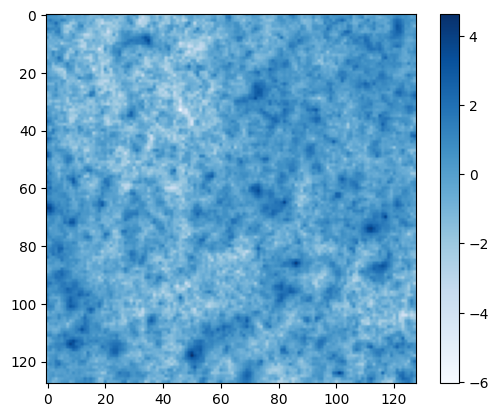

In [88]:
imshow(maps_train_trans[0],cmap="Blues"); colorbar();

In [89]:
x,y,heights = find_peaks2d_tf(maps_train_trans[0],threshold=2)

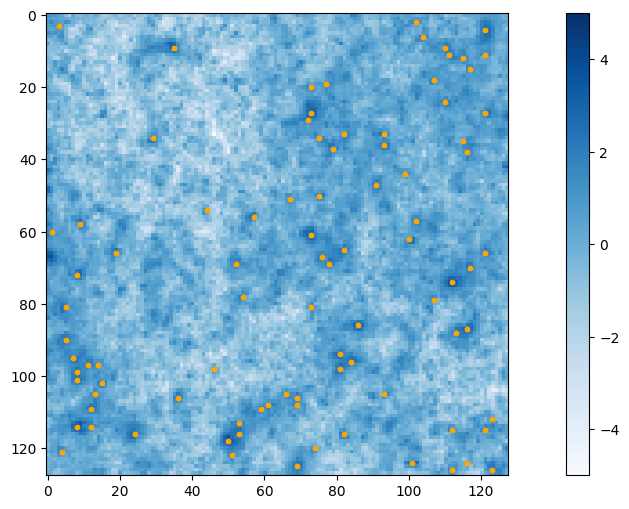

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
mappable = ax.imshow(maps_train_trans[0], cmap='Blues',vmin=-5,vmax=5)
ax.scatter(y,x, s=10, c='orange')  # reverse x and y due to array indexing
#ax.set_axis_off()
colorbar(mappable);


In [91]:
def peaks_histogram_thr(image, bins=None, mask=None, threshold=None, include_border=True):
    """Compute a histogram of peaks in an image.

    Parameters
    ----------
    image : array_like
        Two-dimensional input image.
    bins : int or array_like (1D), optional
        Specification of bin edges or the number of bins to use for the
        histogram. If not provided, a default of 10 bins linearly spaced
        between the image minimum and maximum (inclusive) is used.
    mask : array_like (same shape as `image`), optional
        Boolean array identifying which pixels of `image` to consider/exclude
        in finding peaks. A numerical array will be converted to binary, where
        only zero values are considered masked.

    Returns
    -------
    counts, bin_edges : tuple of 1D numpy arrays
        Histogram and bin boundary values.

    Notes
    -----
    This function calls `find_peaks2d` and then uses `numpy` to compute the
    histogram. If the returned `counts` has N values, `bin_edges` will have
    N + 1 values.

    Examples
    --------
    ...

    """
    # Define bin edges
    if bins is None:
        bins = np.linspace(image.min(), image.max(), 10)
    elif isinstance(bins, int):
        bins = np.linspace(image.min(), image.max(), bins)
    else:
        bins = np.atleast_1d(bins)

    # Compute peaks and histogram
    x, y, heights = find_peaks2d(image, threshold=threshold, mask=mask,include_border=include_border)
    counts, bin_edges = np.histogram(heights, bins)

    return counts, bin_edges

In [97]:
import tensorflow as tf
def _kernel(bw, X, x):
    """Gaussian kernel for KDE"""
    return (1.0 / np.sqrt(2 * np.pi) / bw) * tf.math.exp(-((X - x)**2) / (bw**2 * 2.0))
@tf.function
def peaks_histogram_tf_thr(image, bins=None, mask=None, bw_factor=2.,threshold=None):
    """Compute a histogram of peaks in a 2d image.
    Parameters
    ----------
    image : tensor (2D)
        Two-dimensional input tensor
    bins : int or tensor (1D), optional
        Specification of centers or the number of bins to use for the
        histogram. If not provided, a default of 10 bins linearly spaced
        between the image minimum and maximum (inclusive) is used.
    mask : tensor (same shape as `image`), optional
        Tensor identifying which pixels of `image` to consider/exclude
        in finding peaks. Can either either be numeric (0 or 1) or boolean 
        (false or true)
    bw_factor: float
        Factor by which to divide the bin width to define the bandwidth of the
        smoothing kernel.
    Returns
    -------
    counts, bins : tuple of 1D tensors
        Histogram and bin boundary values. If the returned `counts` has 
        N values, `bin_edges` will have N + 1 values.
     """
    image = tf.cast(image, dtype=tf.float32)
    if bins is None:
        bins = tf.linspace(tf.math.reduce_min(image),
                           tf.math.reduce_max(image), 10)
    elif isinstance(bins, int):
        bins = tf.linspace(tf.math.reduce_min(image),
                           tf.math.reduce_max(image), bins)
    else:
        bins = bins

    x, y, heights = find_peaks2d_tf(image, threshold=threshold, mask=mask)

    # To avoid issues, we clip the image to within the peaks
    heights = tf.clip_by_value(heights, bins[0], bins[-1])

    w = tf.reshape(tf.ones_like(heights), [-1])
    k = _kernel(
        tf.reduce_mean((bins[1:] - bins[:-1])) / bw_factor,
        tf.reshape(heights, [-1, 1]), bins)
    k = k / tf.reduce_sum(k, axis=1, keepdims=True)
    counts = tf.tensordot(k, w, axes=[[0], [0]])

    return counts, bins


In [98]:
thr=-3.
#bins = np.linspace(thr, 5, 10)
bins = tf.linspace(thr, 5, 10)


In [113]:
np.linspace(thr, 5, 10)

array([-3.        , -2.11111111, -1.22222222, -0.33333333,  0.55555556,
        1.44444444,  2.33333333,  3.22222222,  4.11111111,  5.        ])

In [112]:
bins

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-3.        , -2.1111112 , -1.2222222 , -0.33333325,  0.5555556 ,
        1.4444447 ,  2.3333335 ,  3.2222223 ,  4.111111  ,  5.        ],
      dtype=float32)>

In [128]:
counts, tmp = peaks_histogram_tf_thr(maps_gen_trans[0],threshold=None,bins=bins)

In [129]:
tmp

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-3.        , -2.1111112 , -1.2222222 , -0.33333325,  0.5555556 ,
        1.4444447 ,  2.3333335 ,  3.2222223 ,  4.111111  ,  5.        ],
      dtype=float32)>

In [130]:
counts

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8.3900141e-03, 1.6375085e+00, 3.1677622e+01, 1.8766441e+02,
       4.3782324e+02, 3.1457516e+02, 9.8164986e+01, 2.1103422e+01,
       3.0355449e+00, 3.0971652e-01], dtype=float32)>

In [131]:
peaks_histogram_thr(maps_gen_trans[0],threshold=thr,bins=np.linspace(thr, 5, 10))

(array([  0,   5,  81, 359, 492, 178,  43,   7,   1]),
 array([-3.        , -2.11111111, -1.22222222, -0.33333333,  0.55555556,
         1.44444444,  2.33333333,  3.22222222,  4.11111111,  5.        ]))

In [99]:
def counting(data,thr,bins):
    for i in range(data.shape[0]):
        #counts, _ = peaks_histogram_thr(data[i],threshold=thr,bins=bins)
        counts, _ = peaks_histogram_tf_thr(data[i],threshold=thr,bins=bins)
        if i == 0:
            counts_all = counts
        else:
            counts_all = np.vstack((counts_all,counts))
    return np.mean(counts_all,axis=0), np.std(counts_all,axis=0)

In [132]:
counts_train,  counts_train_std = counting(maps_train_trans,thr=None,bins=bins)

In [133]:
counts_train,counts_train_std

(array([9.5361620e-02, 2.5577631e+00, 3.4039577e+01, 1.8431885e+02,
        3.7485977e+02, 3.0130157e+02, 1.1543361e+02, 2.7374928e+01,
        4.8093033e+00, 5.7921594e-01], dtype=float32),
 array([ 0.2780447 ,  3.4098568 , 23.669481  , 60.3108    , 32.68712   ,
        46.590008  , 31.80502   ,  9.797913  ,  2.4149818 ,  0.57155836],
       dtype=float32))

In [134]:
#counts_gen,_ =peaks_histogram_thr(maps_gen_trans[0],threshold=thr,bins=bins)
counts_gen, counts_gen_std = counting(maps_gen_trans,threshold=None,bins=bins)

In [135]:
#counts_wcrg, _ = peaks_histogram_thr(maps_wcrg_gen_trans[0],threshold=thr,bins=bins)
counts_wcrg, counts_wcrg_std = counting(maps_wcrg_gen_trans,threshold=None,bins=bins)

In [136]:
counts_micro, counts_micro_std =  counting(map_micro_gen_trans,threshold=None,bins=bins)

In [137]:
bins.shape, counts_train.shape

(TensorShape([10]), (10,))

In [138]:
bins

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-3.        , -2.1111112 , -1.2222222 , -0.33333325,  0.5555556 ,
        1.4444447 ,  2.3333335 ,  3.2222223 ,  4.111111  ,  5.        ],
      dtype=float32)>

In [139]:
#x_vals = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
x_vals = bins #tf

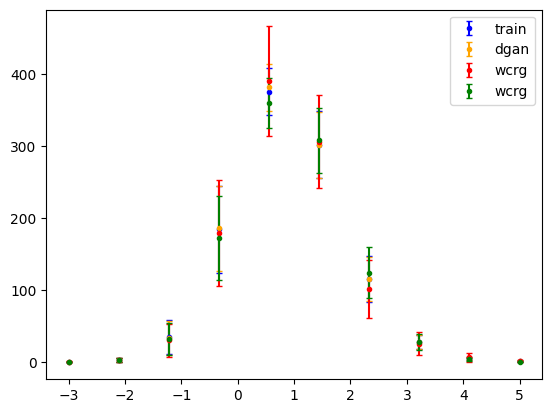

In [140]:
errorbar(x_vals,counts_train,yerr=counts_train_std,label="train",color="blue",
                   fmt='o',ms=3,capsize=2)
errorbar(x_vals,counts_gen,yerr=counts_gen_std,label="dgan",color='orange',
                   fmt='o',ms=3,capsize=2)
errorbar(x_vals,counts_wcrg,yerr=counts_wcrg_std,label="wcrg",color='red',
                   fmt='o',ms=3,capsize=2)
errorbar(x_vals,counts_micro,yerr=counts_micro_std,label="wcrg",color="green",
                   fmt='o',ms=3,capsize=2)

legend();

In [188]:
counts, bins = peaks_histogram_tf_mulscale(maps_train_trans[:1])

In [189]:
counts

[<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([6.7011823e-22, 5.0522480e-14, 8.0895767e-08, 3.1462470e-03,
        3.8328531e+00, 2.1101257e+02, 8.0194568e+02, 3.8217273e+02,
        5.3576534e+01, 5.4564838e+00], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([6.2127583e-14, 5.6136724e-08, 9.5377874e-04, 3.5163122e-01,
        6.1917291e+00, 2.0289694e+01, 4.2777451e+01, 6.6861298e+01,
        7.7411560e+01, 1.3011569e+02], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1.39177656e-10, 1.27087205e-05, 2.26226449e-02, 1.04985595e+00,
        3.23307490e+00, 2.61063719e+00, 2.26507521e+00, 4.14557648e+00,
        1.29475822e+01, 4.57255592e+01], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8.8053685e-01, 1.1916775e-01, 2.9538764e-04, 1.3410561e-08,
        2.0125426e-09, 7.9357204e-05, 5.7312738e-02, 7.5930095e-01,
        6.6034389e-01, 3.5229630e+00], dtype=float32)>]

In [186]:
bins

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-6.0366797 , -4.850807  , -3.664935  , -2.4790628 , -1.2931905 ,
       -0.10731792,  1.0785542 ,  2.2644267 ,  3.4502988 ,  4.636171  ],
      dtype=float32)>

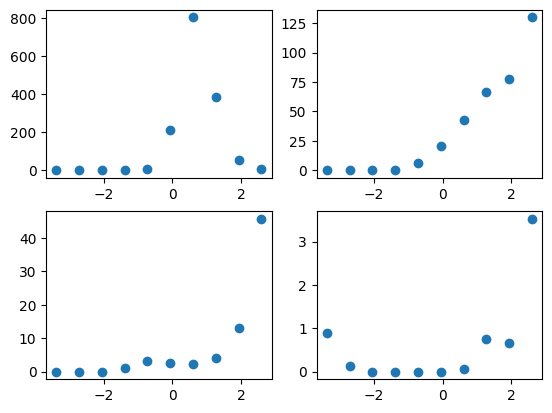

In [145]:
fig,ax = subplots(2,2)
ax[0,0].scatter(bins,counts[0])
ax[0,1].scatter(bins,counts[1])
ax[1,0].scatter(bins,counts[2])
ax[1,1].scatter(bins,counts[3])

In [ ]:
def _get_wavelet_normalization(image, nscales):
    """ Computes normalizing constant for starlet, for given image.
  """
    _, nx, ny = image.get_shape()
    knorm = tf.ones((1, 1, 1, 1), dtype=tf.float32)
    knorm = tf.image.resize_with_crop_or_pad(knorm, nx, ny)
    wt = starlet2d(knorm[..., 0], nscales=nscales)
    return [tf.math.sqrt(tf.reduce_sum(c**2)) for c in wt]

In [153]:
image = tf.cast(maps_train_trans[:1], dtype=tf.float32)
wt = starlet2d(image, nscales=3)
norm_factors = _get_wavelet_normalization(image, nscales=3)

In [157]:
coefs = [wt[i]/norm_factors[i] for i in range(len(wt))]

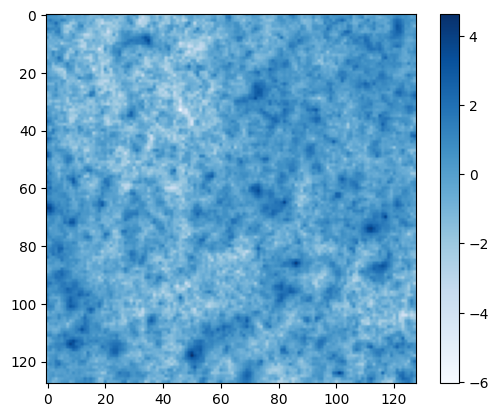

In [170]:
imshow(image.numpy().squeeze(),cmap='Blues');colorbar();

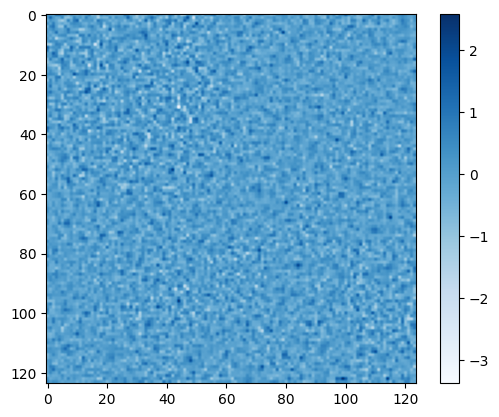

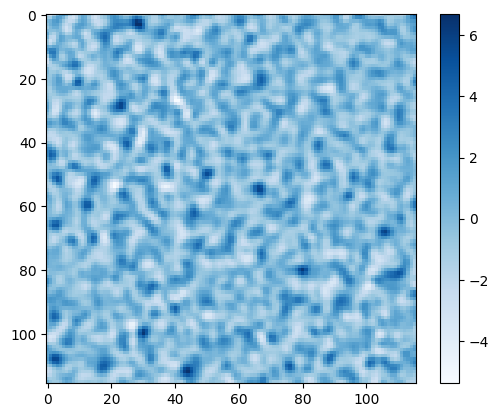

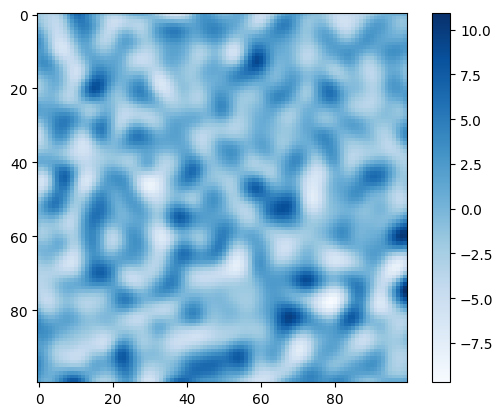

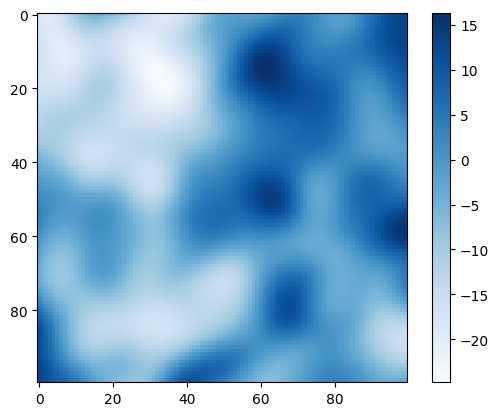

In [179]:
for i,c in enumerate(coefs):
    fig, ax = subplots(1,1)
    c = c.numpy().squeeze()
    img = ax.imshow(c,cmap="Blues");colorbar(img,ax=ax);

In [239]:
image = tf.cast(maps_train_trans[1:2], dtype=tf.float32)
wt = starlet2d(image, nscales=3)
norm_factors = _get_wavelet_normalization(image, nscales=3)

In [240]:
coefs = [wt[i]/norm_factors[i] for i in range(len(wt))]

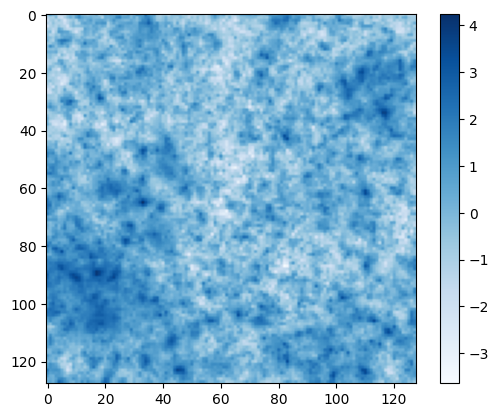

In [241]:
imshow(image.numpy().squeeze(),cmap='Blues');colorbar();

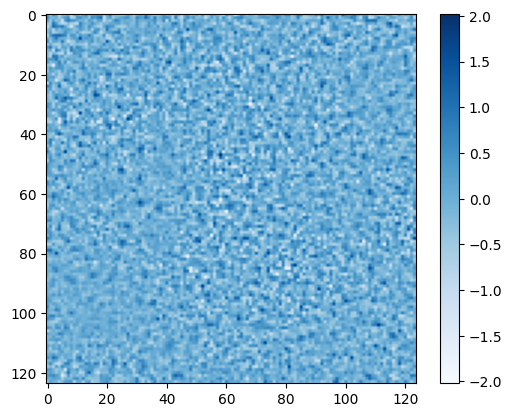

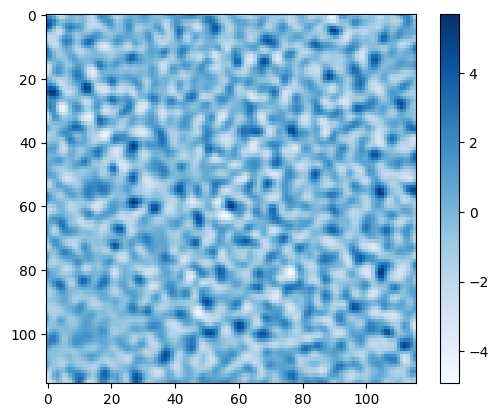

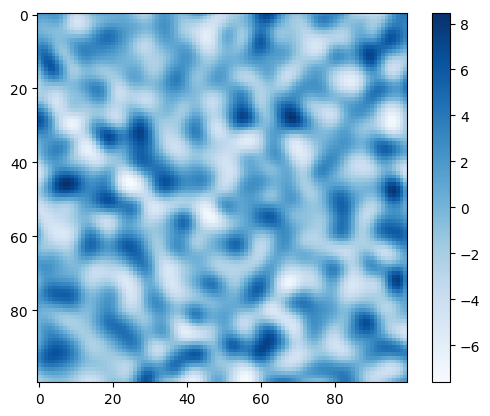

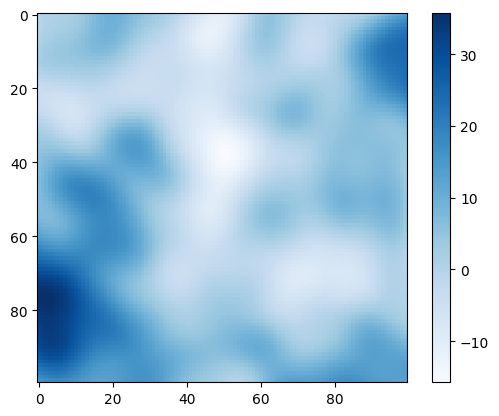

In [242]:
for i,c in enumerate(coefs):
    fig, ax = subplots(1,1)
    c = c.numpy().squeeze()
    img = ax.imshow(c,cmap="Blues");colorbar(img,ax=ax);

In [230]:
#define bins once for all
counts, bins4all = peaks_histogram_tf_mulscale(maps_train_trans[:1],nscales=2)


In [229]:
counts[3]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8.80536854e-01, 1.19386651e-01, 9.72066969e-02, 7.85840213e-01,
       1.16712086e-01, 3.17481492e-04, 1.36512782e-07, 2.65848916e-03,
       1.07250822e+00, 7.92483282e+00], dtype=float32)>

In [195]:
x = tf.convert_to_tensor(counts).numpy()

In [196]:
   x.shape 

(4, 10)

In [203]:
x = x[np.newaxis]

In [204]:
y = np.ones_like(x)

In [205]:
np.vstack((x,y)).shape

(2, 4, 10)

In [235]:
def counting_multiscale(data,bins,nscales=1):
    for i in range(data.shape[0]):
        counts, _ = peaks_histogram_tf_mulscale(data[i][np.newaxis],bins=bins,nscales=nscales)
        counts = tf.convert_to_tensor(counts).numpy()
        counts = counts[np.newaxis]
        if i == 0:
            counts_all = counts
        else:
            counts_all = np.vstack((counts_all,counts))
    return np.mean(counts_all,axis=0), np.std(counts_all,axis=0)

In [243]:
counts_ms_train,  counts_ms_train_std = counting_multiscale(maps_train_trans,bins=bins4all)
counts_ms_gen,  counts_ms_gen_std = counting_multiscale(maps_gen_trans,bins=bins4all)
counts_ms_wcrg, counts_ms_wcrg_std = counting_multiscale(maps_wcrg_gen_trans,bins=bins4all)
counts_ms_micro, counts_ms_micro_std = counting_multiscale(map_micro_gen_trans, bins=bins4all)

In [237]:
counts_ms_train.shape

(2, 10)

In [251]:
counts_ms_train_std

array([[6.92176465e-20, 5.63864602e-13, 1.11645690e-07, 1.02787372e-03,
        8.95182490e-01, 3.40678711e+01, 2.49127846e+01, 4.95704498e+01,
        1.43751335e+01, 1.70913005e+00],
       [6.24029350e+00, 4.07857466e+00, 4.55660725e+00, 5.38607740e+00,
        5.90466118e+00, 5.96539164e+00, 5.62443590e+00, 4.97607088e+00,
        5.24041510e+00, 2.71582241e+01]], dtype=float32)

In [252]:
counts_ms_wcrg_std

array([[1.17127443e-19, 1.10513812e-12, 2.17817302e-07, 1.55701046e-03,
        1.10082722e+00, 2.09328842e+01, 1.19790375e+02, 7.29582901e+01,
        5.01349878e+00, 2.48104349e-01],
       [4.90090084e+00, 3.51704526e+00, 4.20320511e+00, 5.33601332e+00,
        6.27495241e+00, 6.56186295e+00, 6.22195148e+00, 5.95750904e+00,
        5.05771685e+00, 3.00657253e+01]], dtype=float32)

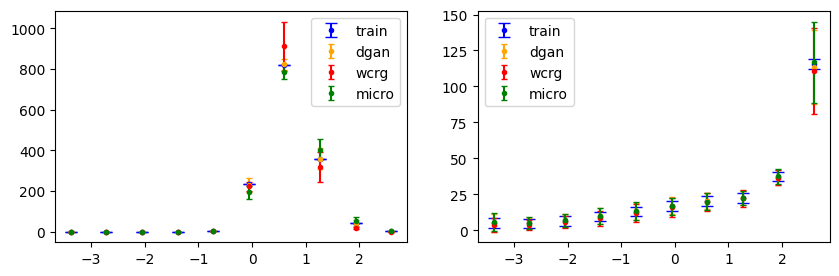

In [253]:
fig,ax = subplots(1,2,figsize=(10,3))
ax[0].errorbar(bins4all,counts_ms_train[0],yerr=counts_train_std[0],label="train",color="blue",
                   fmt='o',ms=3,capsize=4)
ax[0].errorbar(bins4all,counts_ms_gen[0],yerr=counts_ms_gen_std[0],label="dgan",color='orange',
                   fmt='o',ms=3,capsize=2)
ax[0].errorbar(bins4all,counts_ms_wcrg[0],yerr=counts_ms_wcrg_std[0],label="wcrg",color='red',
                   fmt='o',ms=3,capsize=2)
ax[0].errorbar(bins4all,counts_ms_micro[0],yerr=counts_ms_micro_std[0],label="micro",color="green",
                   fmt='o',ms=3,capsize=2)
ax[0].legend()

ax[1].errorbar(bins4all,counts_ms_train[1],yerr=counts_train_std[1],label="train",color="blue",
                   fmt='o',ms=3,capsize=4)
ax[1].errorbar(bins4all,counts_ms_gen[1],yerr=counts_ms_gen_std[1],label="dgan",color='orange',
                   fmt='o',ms=3,capsize=2)
ax[1].errorbar(bins4all,counts_ms_wcrg[1],yerr=counts_ms_wcrg_std[1],label="wcrg",color='red',
                   fmt='o',ms=3,capsize=2)
ax[1].errorbar(bins4all,counts_ms_micro[1],yerr=counts_ms_micro_std[1],label="micro",color="green",
                   fmt='o',ms=3,capsize=2)
ax[1].legend();
